In [1]:
from keras.layers import *
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils import class_weight
from keras.utils import to_categorical
from tqdm.notebook import tqdm as tqdm
# from tensorflow.keras import Model
from keras.models import Sequential, load_model
from keras.callbacks import ModelCheckpoint
from sklearn.utils import shuffle
from keras import models, layers, Model
from datetime import datetime

from keras import backend as K
from skimage import transform
from skimage import io

import keras

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np

import collections
import json
import cv2
import os

Using TensorFlow backend.


In [2]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# mapping_data = json.load(open("Dental_Data/PBL/Major_10_clahe/mapping.json", "r"))
# filter_data  = { path: int(state) for path, state in mapping_data.items() if int(state) >= 0 }
# filter_data  = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }

In [4]:
mapping_clahe_data = json.load(open("Dental_Data/PBL/Major_10_clahe/mapping.json", "r"))
mapping_data = json.load(open("Dental_Data/PBL/Major_10/mapping.json", "r"))
mapping_clahe_data_Flip = json.load(open("Dental_Data/PBL/Major_10_clahe_Flip/mapping.json", "r"))
mapping_data_Flip = json.load(open("Dental_Data/PBL/Major_10_Flip/mapping.json", "r"))

filter_normal_data       = { path: max(list(map(int, state))) for path, state in mapping_data.items() if max(list(map(int, state))) >= 0 }
filter_normal_data_Flip  = { path.replace("Major_10", "Major_10_Flip"): max(list(map(int, state))) for path, state in mapping_data_Flip.items() if max(list(map(int, state))) >= 0 }

filter_clahe_data        = { path: max(list(map(int, state))) for path, state in mapping_clahe_data.items() if max(list(map(int, state))) >= 0 }
filter_clahe_data_Flip   = { path.replace("Major_10_clahe", "Major_10_clahe_Flip"): max(list(map(int, state))) for path, state in mapping_clahe_data_Flip.items() if max(list(map(int, state))) >= 0 }

        
filter_data = collections.OrderedDict()

for normal, normal_flip, clahe, clahe_flip in zip(filter_normal_data.keys(), filter_normal_data_Flip.keys(), filter_clahe_data.keys(), filter_clahe_data_Flip.keys()):
        filter_data[normal] = filter_normal_data[normal]
        filter_data[normal_flip] = filter_normal_data_Flip[normal_flip]
        filter_data[clahe]  = filter_clahe_data[clahe]
        filter_data[clahe_flip]  = filter_clahe_data_Flip[clahe_flip]

In [5]:
def json_2_dataframe_PBL(dataframe, data):
        data_dict, counter = collections.OrderedDict(), 0
        for path, state in tqdm(data.items()):
                item = { "Path": path, "State": state, "Class": state }
#                 item = { "Path": path, "State": state, "Class": state-1 if state > 1 else 0  }
                path_split = path.split("_")
                item["tooth_num"] =  int(path_split[-2])
                if item["tooth_num"] in [1, 16, 17, 32]: continue
                item["angle"] = int(path_split[-1].split(".")[0])
#                 item["tooth_num"] =  int(path_split[5]) if str.isdigit(path_split[5]) else int(path_split[6])
#                 item["angle"] = int(path_split[-2])
                data_dict[counter] = item
                counter += 1        
        dataframe = dataframe.from_dict(data_dict, "index")
        return dataframe

    
    
PBL_Columns = ["Path", "State", "Class"]
dataset = pd.DataFrame(columns=PBL_Columns)
dataset = json_2_dataframe_PBL(dataset, filter_data)
dataset

,Path,State,Class,tooth_num,angle
0,Dental_Data/PBL/Major_10/08-56-47-242_000408 1...,1,1,6,-10
1,Dental_Data/PBL/Major_10_Flip/08-56-47-242_000...,1,1,6,-10
2,Dental_Data/PBL/Major_10_clahe/09-34-05-078_00...,1,1,6,-10
3,Dental_Data/PBL/Major_10_clahe_Flip/09-34-05-0...,1,1,6,-10
4,Dental_Data/PBL/Major_10/08-56-47-261_000408 1...,1,1,6,-9
...,...,...,...,...,...
280075,Dental_Data/PBL/Major_10_clahe_Flip/10-07-43-8...,2,2,7,8
280076,Dental_Data/PBL/Major_10/09-33-54-922_710456 1...,2,2,7,9
280077,Dental_Data/PBL/Major_10_Flip/09-33-54-922_710...,2,2,7,9
280078,Dental_Data/PBL/Major_10_clahe/10-07-43-914_71...,2,2,7,9


In [6]:
 def split_dataframe(dataframe, arguscale=20):
                data_volume = len(dataframe) // arguscale
                training_range = (0, int(round(data_volume * 0.6, 0)))
                valid_range    = (training_range[1], int(training_range[1] + round(data_volume * 0.2, 0)) )
                test_range     = (valid_range[1], int(valid_range[1] + round(data_volume * 0.2, 0)))


                training_idx_range     = ( training_range[0] * arguscale, training_range[1] * arguscale )
                valid_idx_range        = ( valid_range[0] * arguscale   , valid_range[1]    * arguscale )
                test_idx_range         = ( test_range[0] * arguscale    , test_range[1]     * arguscale )

                train_data = dataframe.iloc[training_idx_range[0]:training_idx_range[1], :].reset_index(drop=True)
                valid_data = dataframe.iloc[valid_idx_range[0]:valid_idx_range[1], :].reset_index(drop=True)
                test_data  = dataframe.iloc[test_idx_range[0]:, :].reset_index(drop=True)

                train_data = shuffle(train_data).reset_index(drop=True)
                valid_data = shuffle(valid_data).reset_index(drop=True)
                test_data  = shuffle(test_data).reset_index(drop=True)

                return train_data, valid_data, test_data  

class DataGenerator(keras.utils.Sequence):
        'Generates data for Keras'
        def __init__(self, list_IDs, labels, batch_size=32, dim=(256, 256), n_channels=1,
                     n_classes=10, shuffle=True, resize_setting=(256, 256), Flip=True):
                'Initialization'
                self.dim = dim
                self.batch_size = batch_size // 2 if Flip else batch_size
                self.labels = labels
                self.list_IDs = list(list_IDs)
                self.n_channels = n_channels
                self.n_classes = n_classes
                self.shuffle = shuffle
                self.on_epoch_end()
                self.resize_setting = resize_setting
                self.Flip = Flip

        def __len__(self):
                'Denotes the number of batches per epoch'
                return int(np.ceil(len(self.list_IDs) / self.batch_size))

        def __getitem__(self, index):
                'Generate one batch of data'
                # Generate indexes of the batch
                end = (index+1)*self.batch_size if (index+1)*self.batch_size < len(self.indexes) else len(self.indexes)
                indexes = self.indexes[index*self.batch_size:end] 

                # Find list of IDs
                list_IDs_temp = [self.list_IDs[k] for k in indexes]         
                # Generate data
                X, y = self.__data_generation(list_IDs_temp)
               
                return X, y

        def on_epoch_end(self):
                'Updates indexes after each epoch'
                self.indexes = np.arange(len(self.list_IDs))
                if self.shuffle == True:
                        np.random.shuffle(self.indexes)

        def __data_generation(self, list_IDs_temp):
            
                # Initialization
                image_array_size = (
                                        self.batch_size * 2 if self.Flip else self.batch_size, 
                                        *self.dim,
                                        self.n_channels
                                   )
                X = np.zeros(image_array_size, dtype=np.uint8)
                y = np.array([0]* (self.batch_size * 2 if self.Flip else self.batch_size))
                
            
                for i, ID in enumerate(list_IDs_temp):
                        image = cv2.imread(ID, 0)
                        image = cv2.resize(image, (self.resize_setting[1], self.resize_setting[0]))
                        H_flip = cv2.flip(image, 1)

                        image = np.reshape(image, (*image.shape, 1))
                        H_flip = np.reshape(H_flip, (*H_flip.shape, 1))
                         
                        X[i,], y[i] =  image, self.labels[ID]
                        if self.Flip: X[i+self.batch_size], y[i+self.batch_size] = H_flip, self.labels[ID]
                        
                return X, to_categorical(y, num_classes=self.n_classes)
            
def generator(dataframe, arguscale=20, train_flip=True, valid_flip=True, test_flip=False, batch_size=32):
        
        stage_0 = dataset[dataset["State"] == 0]
        stage_1 = dataset[dataset["State"] == 1]
        stage_2 = dataset[dataset["State"] == 2]
        stage_3 = dataset[dataset["State"] == 3]
        
        train_data_0, valid_data_0, test_data_0 = split_dataframe(stage_0.reset_index(drop=True), arguscale=80) 
        train_data_1, valid_data_1, test_data_1 = split_dataframe(stage_1.reset_index(drop=True), arguscale=80) 
        train_data_2, valid_data_2, test_data_2 = split_dataframe(stage_2.reset_index(drop=True), arguscale=80) 
        train_data_3, valid_data_3, test_data_3 = split_dataframe(stage_3.reset_index(drop=True), arguscale=80) 
        
        train_min, valid_min, test_min = len(train_data_3), len(valid_data_3), len(test_data_3)
#         train_min, valid_min, test_min = len(train_data_2), len(valid_data_2), len(test_data_2)

#         train_dataset   = pd.concat([train_data_0.iloc[:train_min//2, :], train_data_1.iloc[:train_min//2, :], 
#                                      train_data_2.iloc[:train_min, :], train_data_3])
        
#         valid_dataset   = pd.concat([valid_data_0.iloc[:valid_min//2, :], valid_data_1.iloc[:valid_min//2, :], 
#                                      valid_data_2.iloc[:valid_min, :], valid_data_3])
        
#         test_dataset    = pd.concat([test_data_0.iloc[:test_min//2, :] , test_data_1.iloc[:test_min//2, :] , 
#                                      test_data_2.iloc[:test_min, :] , test_data_3 ])
        
        train_dataset   = pd.concat([train_data_0.iloc[:train_min, :], train_data_1.iloc[:train_min, :], 
                                     train_data_2.iloc[:train_min, :], train_data_3])
        
        valid_dataset   = pd.concat([valid_data_0.iloc[:valid_min, :], valid_data_1.iloc[:valid_min, :], 
                                     valid_data_2.iloc[:valid_min, :], valid_data_3])
        
        test_dataset    = pd.concat([test_data_0.iloc[:test_min, :] , test_data_1.iloc[:test_min, :] , 
                                     test_data_2.iloc[:test_min, :], test_data_3])
                                     
        
        common_params = {
                              'batch_size': batch_size,
                              'n_classes' : len(np.unique(dataframe.Class)),
                              'n_channels': 1,
                              'shuffle'   : False,
                              'resize_setting': (200, 180),
                              'dim': (200, 180)
                 }
        
        train_param = { 'Flip': train_flip, **common_params }
        valid_param = { 'Flip': valid_flip, **common_params }
        test_param  = { 'Flip': test_flip , **common_params }
        
        train_dataset = shuffle(train_dataset)
        valid_dataset = shuffle(valid_dataset)
        test_dataset  = shuffle(test_dataset)
        
        train_dataset_dict = collections.OrderedDict(zip(train_dataset.Path, train_dataset.Class))
        valid_dataset_dict = collections.OrderedDict(zip(valid_dataset.Path, valid_dataset.Class))
        test_dataset_dict  = collections.OrderedDict(zip(test_dataset.Path, test_dataset.Class))
        

        train_generator = DataGenerator(train_dataset["Path"], train_dataset_dict ,**train_param)
        valid_generator = DataGenerator(valid_dataset["Path"], valid_dataset_dict ,**valid_param)
        test_generator  = DataGenerator(test_dataset ["Path"], test_dataset_dict  ,**test_param)
        
        return train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator

In [7]:
train_dataset, valid_dataset, test_dataset, train_generator, valid_generator, test_generator = generator(dataset, train_flip=True, valid_flip=True, test_flip=False)

In [8]:
def CNN_Net(input_shape, classes):
        model = models.Sequential()
        
        model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Conv2D(64, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Conv2D(128, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
       
        
        model.add(Conv2D(256, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        
        model.add(Conv2D(512, (3, 3), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(512, (1, 6), activation='relu'))
#         model.add(BatchNormalization())
        
        
        model.add(Flatten())
#         model.add(Dense(128, activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.5))
        
#         model.add(Dense(64, activation='relu'))
#         model.add(BatchNormalization())
#         model.add(Dropout(0.5))
        
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        return model
    

        
def VGG_Net(input_shape, classes):
        model = models.Sequential()
        
        model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv2D(64, (1, 1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (1, 1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (1, 1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (1, 1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
        model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(Conv2D(32, (1, 1), padding = 'same', activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(256, (3, 3), padding = 'same', activation='relu'))
#         model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
#         model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
#         model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
#         model.add(MaxPooling2D((2, 2)))
        
#         model.add(Conv2D(128, (3, 3), padding = 'same', activation='relu'))
#         model.add(MaxPooling2D((2, 2)))
        
        model.add(Flatten())
        model.add(Dense(1024, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(512, activation='relu'))
        model.add(Dropout(0.3))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(classes, activation='softmax'))
        model.compile(loss=keras.losses.categorical_crossentropy,
                      optimizer=keras.optimizers.Adadelta(),
                      metrics=['accuracy'])
        
        return model
    

    

In [9]:
# class_weights = class_weight.compute_class_weight('balanced', np.unique(train_dataset["Class"]), train_dataset["Class"])
class_weights = { 0: 1.,
                  1: 2.,
                  2: 4.}
model = CNN_Net(input_shape=(200, 180, 1), classes=len(np.unique(train_dataset["Class"])))
model.summary()
print(class_weights)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 198, 178, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 198, 178, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 99, 89, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 97, 87, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 97, 87, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 48, 43, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 46, 41, 128)      

In [10]:
# train_dataset = shuffle(train_dataset)
# valid_dataset = shuffle(valid_dataset)
# test_dataset  = shuffle(test_dataset)
# resize_setting = (256, 256)
# classes = len(np.unique(train_dataset["Class"]))

# def path_2_images(path_list, resize_setting, apply_GCN=False):        
#         images = np.zeros((len(path_list), *resize_setting, 1))
#         count = 0
#         for path in tqdm(path_list):
# #                 image = io.imread(path, as_gray=True)
# #                 image = transform.resize(image, resize_setting)
# #                 image = np.reshape(image, (*image.shape, 1))
#                 image = cv2.imread(path, 0)
#                 if apply_GCN:image = GCN(image)
#                 image = cv2.resize(image, resize_setting)
#                 image = np.reshape(image, (*image.shape, 1))
                
#                 images[count, ] = image
#                 count += 1
#         return images


# X_train, y_train = path_2_images(train_dataset["Path"], resize_setting), to_categorical(train_dataset["Class"], classes)  
# X_val, y_val     = path_2_images(valid_dataset["Path"], resize_setting), to_categorical(valid_dataset["Class"], classes) 
# X_test, y_test   = path_2_images(test_dataset ["Path"], resize_setting), to_categorical(test_dataset ["Class"], classes)
# epochs     = 100

# filepath="parameter/CNN_weights_best_clahe.hdf5"
# checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True,
# mode='max')
# callbacks_list = [checkpoint]

# history = model.fit(X_train, y_train, validation_data=(X_val, y_val), shuffle=True, epochs=epochs, batch_size=128, callbacks=callbacks_list)

In [11]:
epochs     = 70
filepath="parameter/CNN_1_200_180_4_classes.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = model.fit_generator(
                        generator=train_generator,
                        validation_data=valid_generator,
                        epochs=epochs,
                        workers=2,
                        shuffle=True,
                        callbacks=callbacks_list
                       )


Epoch 1/70
2060/2060 [==============================] - 781s 379ms/step - loss: 0.9590 - accuracy: 0.6566 - val_loss: 1.7643 - val_accuracy: 0.6270

Epoch 00001: val_accuracy improved from -inf to 0.62702, saving model to parameter/CNN_1_200_180_4_classes.h5
Epoch 2/70
2060/2060 [==============================] - 127s 62ms/step - loss: 0.3545 - accuracy: 0.8696 - val_loss: 1.2559 - val_accuracy: 0.6089

Epoch 00002: val_accuracy did not improve from 0.62702
Epoch 3/70
2060/2060 [==============================] - 128s 62ms/step - loss: 0.1677 - accuracy: 0.9418 - val_loss: 2.3107 - val_accuracy: 0.6042

Epoch 00003: val_accuracy did not improve from 0.62702
Epoch 4/70
2060/2060 [==============================] - 128s 62ms/step - loss: 0.0798 - accuracy: 0.9729 - val_loss: 2.2196 - val_accuracy: 0.6133

Epoch 00004: val_accuracy did not improve from 0.62702
Epoch 5/70
2060/2060 [==============================] - 128s 62ms/step - loss: 0.0487 - accuracy: 0.9832 - val_loss: 3.4352 - val_ac


Epoch 00040: val_accuracy did not improve from 0.62702
Epoch 41/70
2060/2060 [==============================] - 128s 62ms/step - loss: 2.4040e-07 - accuracy: 1.0000 - val_loss: 7.4792 - val_accuracy: 0.6157

Epoch 00041: val_accuracy did not improve from 0.62702
Epoch 42/70
2060/2060 [==============================] - 127s 62ms/step - loss: 2.2459e-07 - accuracy: 1.0000 - val_loss: 7.6830 - val_accuracy: 0.6167

Epoch 00042: val_accuracy did not improve from 0.62702
Epoch 43/70
2060/2060 [==============================] - 127s 62ms/step - loss: 2.1391e-07 - accuracy: 1.0000 - val_loss: 7.7030 - val_accuracy: 0.6177

Epoch 00043: val_accuracy did not improve from 0.62702
Epoch 44/70
2060/2060 [==============================] - 127s 62ms/step - loss: 2.0440e-07 - accuracy: 1.0000 - val_loss: 7.5646 - val_accuracy: 0.6168

Epoch 00044: val_accuracy did not improve from 0.62702
Epoch 45/70
2060/2060 [==============================] - 128s 62ms/step - loss: 1.9035e-07 - accuracy: 1.0000 - 

In [12]:
def plot_result(history):
        plt.style.use('fivethirtyeight')
        plt.figure(figsize=(16,5))
        
        plt.subplot(121)
        plt.title("Loss")
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label = 'Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend(loc='lower right')
        
        plt.subplot(122)
        plt.title("Accuracy")
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.ylim([0.1, 1.5])
        plt.legend(loc='lower right')
        plt.show()
def plot_confusion_matrix(confusion_matrix, classes):
        df_cm = pd.DataFrame(confusion_matrix, range(classes), range(classes))
        sns.set(font_scale=1.4)
        sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, cmap='YlGnBu', fmt='g') # font size
        plt.title("Confusion Matrix")
        plt.xlabel('prediction' , fontsize=18)
        plt.ylabel('ground truth', fontsize=18)
        plt.show()

In [13]:
# pred = model.predict_generator(test_generator, verbose=1)
# pred = np.argmax(pred, axis=1)
# y = test_dataset.Class
# confusion = confusion_matrix(y, pred)
# print("Accuracy  = {:2f}".format((pred == y).mean()))

# plot_result(history)
# plot_confusion_matrix(confusion, len(np.unique(dataset.Class)) )

Test Loss = 1.0903926929678112
Test Acc  = 0.6158088445663452
Accuracy = 61.58


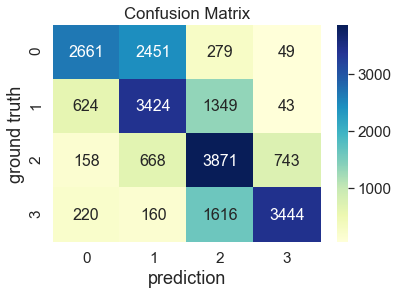

In [14]:
test_dataset  = shuffle(test_dataset)
resize_setting = (200, 180)
classes = len(np.unique(train_dataset["Class"]))

def flip_dataset(dataset, resize_setting):        
        images = np.zeros((len(dataset["Path"]) * 2 , *resize_setting, 1))
        labels = np.zeros((len(dataset["Class"]) * 2))
        count = 0
                          
        for path, label in zip(dataset["Path"], dataset["Class"]):
                image = cv2.imread(path, 0)
                image = cv2.resize(image, (resize_setting[1], resize_setting[0]) )
                
                H_flip = cv2.flip(image, 1)
                image = np.reshape(image, (*image.shape, 1))
                H_flip = np.reshape(H_flip, (*H_flip.shape, 1))
                
                images[count, ] = image
                images[count + len(dataset["Path"]), ] = H_flip
                labels[count] =  label
                labels[count + len(dataset["Path"]) ] =  label
                count += 1
        return images, to_categorical(labels, len(np.unique(dataset["Class"])))


X_test, y_test = flip_dataset(test_dataset, resize_setting)
model = load_model(filepath)
results = model.evaluate(X_test, y_test, verbose=2, batch_size=8)
print("Test Loss = {}\nTest Acc  = {}".format(*results))

prediction = model.predict_classes(X_test, batch_size=8)
y = np.argmax(y_test, axis=1)
print("Accuracy = %.2f" % ( (y==prediction).mean()*100 ) )
confusion = confusion_matrix(y, prediction)
plot_confusion_matrix(confusion, classes)

In [15]:
# train_predict = model.predict_classes(X_train)
# train_dataset["Predict"] = train_predict
# train_dataset["Match"]   = np.where(train_dataset["Predict"] == train_dataset["Class"], 1, 0)  

# valid_predict = model.predict_classes(X_val)
# valid_dataset["Predict"] = valid_predict
# valid_dataset["Match"]   = np.where(valid_dataset["Predict"] == valid_dataset["Class"], 1, 0)  

# test_predict = model.predict_classes(X_test)
# test_dataset["Predict"] = test_predict
# test_dataset["Match"]   = np.where(test_dataset["Predict"] == test_dataset["Class"], 1, 0)

In [16]:
train_dataset_noflip, valid_dataset_noflip, test_dataset_noflip,\
train_generator_noflip, valid_generator_noflip, test_generator_noflip = generator(dataset, train_flip=False, valid_flip=False, test_flip=False, batch_size=20)

train_predict = model.predict_generator(train_generator_noflip, verbose=1)
train_dataset_noflip["Predict"] = np.argmax(train_predict, axis=1)

valid_predict = model.predict_generator(valid_generator_noflip, verbose=1)
valid_dataset_noflip["Predict"] = np.argmax(valid_predict, axis=1)

test_predict = model.predict_generator(test_generator_noflip, verbose=1)
test_dataset_noflip["Predict"] = np.argmax(test_predict, axis=1)

544/544 [==============================] - 107s 196ms/step


In [17]:
train_dataset_noflip.to_csv("train_predict_4_flip.csv", index=False)
valid_dataset_noflip.to_csv("valid_predict_4_flip.csv", index=False)
test_dataset_noflip.to_csv("test_predict_4_flip.csv", index=False)

In [18]:
# def statistic(dataframe):
#         results = pd.DataFrame(columns=["Class 0", "Class 1", "Class 2"])
#         for i in range(4):
#                 data = {
#                     "Class 0": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==0)]),
#                     "Class 1": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==1)]),
#                     "Class 2": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==2)]),
#                 }
                
#                 total = data["Class 0"] + data["Class 1"] + data["Class 2"]
#                 if i <= 1: Acc = data["Class 0"] / total * 100
#                 if i == 2: Acc = data["Class 1"] / total * 100
#                 if i == 3: Acc = data["Class 2"] / total * 100

#                 data["Acc"] = "{}%".format(int(round(Acc,0)))
#                 results = results.append(data, ignore_index=True)
#         return results

def statistic(dataframe):
        results = pd.DataFrame(columns=["Class 0", "Class 1", "Class 2", "Class 3"])
        for i in range(4):
                data = {
                    "Class 0": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==0)]),
                    "Class 1": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==1)]),
                    "Class 2": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==2)]),
                    "Class 3": len(dataframe[(dataframe["State"]==i) & (dataframe["Predict"]==3)]),
                }
                
                total = data["Class 0"] + data["Class 1"] + data["Class 2"] + data["Class 3"]
                if i == 0: Acc = data["Class 0"] / total * 100
                if i == 1: Acc = data["Class 1"] / total * 100
                if i == 2: Acc = data["Class 2"] / total * 100
                if i == 3: Acc = data["Class 3"] / total * 100

                data["Acc"] = "{}%".format(int(round(Acc,0)))
                results = results.append(data, ignore_index=True)
        return results
    
    

In [19]:
statistic(valid_dataset_noflip)

,Class 0,Class 1,Class 2,Class 3,Acc
0,1269,1311,133,7,47%
1,358,1714,623,25,63%
2,30,211,2088,391,77%
3,90,73,735,1822,67%


In [20]:
statistic(test_dataset_noflip)

,Class 0,Class 1,Class 2,Class 3,Acc
0,1354,1184,155,27,50%
1,305,1730,665,20,64%
2,87,336,1864,433,69%
3,110,80,808,1722,63%


In [21]:
def gradcam(model, x, layer_name, image, idx):
                preds = model.predict(x)
                pred_class = np.argmax(preds[0])
                pred_output = model.output[:, pred_class]
                pred_output = model.output
                conv_layer = model.get_layer(layer_name)
                grads = K.gradients(pred_output, conv_layer.output)[0]
                pooled_grads = K.sum(grads, axis=(0, 1, 2))
                iterate = K.function([model.input], [pooled_grads, conv_layer.output[0]])
                pooled_grads_value, conv_layer_output_value = iterate([x])

                for i in range(pooled_grads_value.shape[0]):
                        conv_layer_output_value[:, :, i] *= (pooled_grads_value[i])
                heatmap = np.sum(conv_layer_output_value, axis=-1)
                
                image = image.astype(np.uint8)
                image = cv2.cvtColor(image, cv2.COLOR_GRAY2RGB)

               
        
                # ReLU
                heatmap = np.maximum(heatmap, 0)
                
                num_zeros = (heatmap == 0).sum()
                if num_zeros > 0.5 * heatmap.shape[0] * heatmap.shape[1]: return False
                
                
                # normalize
                heatmap /= np.max(heatmap)
                heatmap = cv2.resize(heatmap, (image.shape[1], image.shape[0]))
                heatmap = np.uint8(255 * heatmap)
                plt.figure(figsize=(16,5))
                plt.xticks([]), plt.yticks([])
                plt.imshow(image, alpha=0.6)
                plt.imshow(heatmap, cmap='jet', alpha=0.4)
#                 plt.savefig("%s/heatmap_%d.png" % (output_dir, idx))
                plt.show()
                
                return True
        

Conv_layers = [ layer.name for layer in model.layers if 'conv' in layer.name ]
same_generator = ( X_test[idx]  for idx, (truth, pred) in enumerate(zip(y, prediction)) if truth == pred )

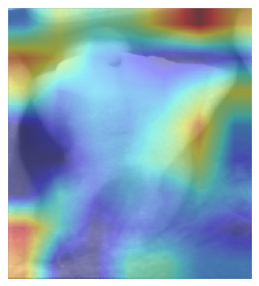

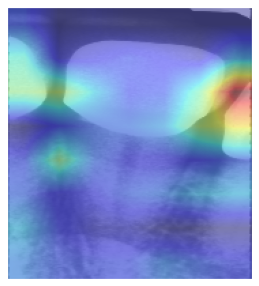

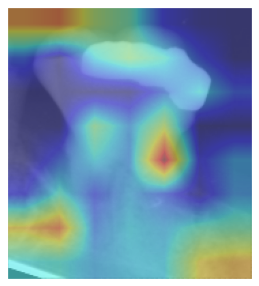

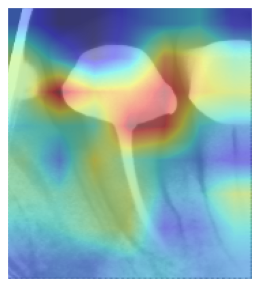

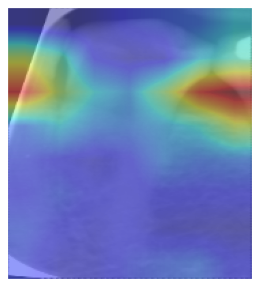

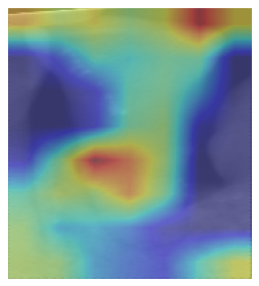

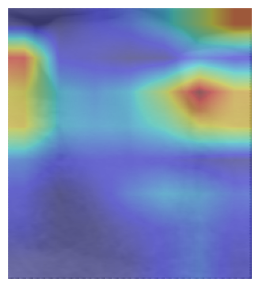

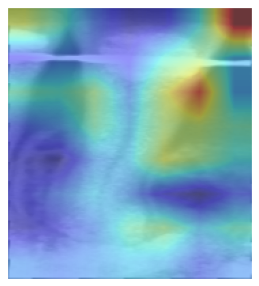

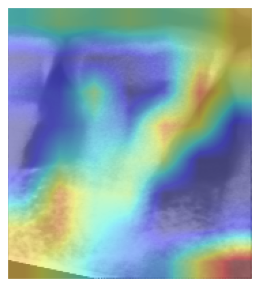

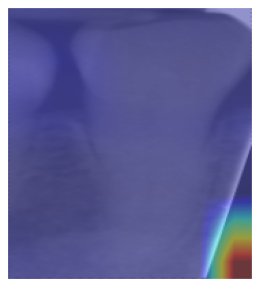

In [22]:
heapmap_count = 0
for idx, i in enumerate(same_generator):
        state = gradcam(model, i.reshape(1, *i.shape), Conv_layers[-1], i, idx)
        if state: heapmap_count += 1
        if heapmap_count >= 10: break